TODO not fitting the intensity scale might cause problems for larger offset values

check convergence speed for large offsets. might need more epochs

In [1]:
from functools import reduce

from ptycho.misc import *

from glob import glob
import numpy as np
import dill
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# TODO compare experimental and experimental2. Think outliers need to be removed from experimental2
#prefixes = ['grf', 'experimental', 'lines_nophi2']
#prefixes = ['grf2', 'experimental2', 'lines_nophi2']
prefixes = ['grf3', 'experimental3', 'lines_nophi3']

prefixes = reduce(lambda a, b: a + b, [glob('{}/*/'.format(prefix)) for prefix in prefixes])

add = lambda a, b: a + b
params_paths = reduce(add, [glob('{}params.dill'.format(p)) for p in prefixes])
hpaths = reduce(add, [glob('{}history.dill'.format(p)) for p in prefixes])

def load_dill(path):
    print('load', path)
    with open(path, 'rb') as f:
        return dill.load(f)

params = [load_dill(p) for p in params_paths]


from ptycho import params as p

/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-06-03 18:38:06.753859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 18:38:06.836659: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-03 18:38:07.170855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared o

load grf3/06-03-2023-17.37.13_none/params.dill
load grf3/06-03-2023-15.01.24_PINN,NLL,overlaps/params.dill
load grf3/06-03-2023-13.06.20_PINN,NLL/params.dill
load grf3/06-03-2023-04.39.26_PINN/params.dill
load grf3/06-03-2023-06.22.09_PINN,overlaps/params.dill
load grf3/06-03-2023-08.35.46_PINN,overlaps/params.dill
load grf3/06-03-2023-12.51.12_PINN,overlaps/params.dill
load grf3/06-03-2023-04.14.41_PINN,overlaps/params.dill
load grf3/06-03-2023-11.30.49_none/params.dill
load grf3/06-03-2023-02.24.24_overlaps/params.dill
load grf3/06-03-2023-10.45.54_PINN,NLL,overlaps/params.dill
load grf3/06-03-2023-17.27.28_PINN/params.dill
load grf3/06-03-2023-15.11.57_PINN,NLL/params.dill
load grf3/06-03-2023-08.46.12_overlaps/params.dill
load grf3/06-03-2023-06.47.10_PINN/params.dill
load grf3/06-03-2023-08.25.08_PINN,NLL,overlaps/params.dill
load grf3/06-03-2023-06.56.56_none/params.dill
load grf3/06-03-2023-09.10.38_none/params.dill
load grf3/06-03-2023-15.06.52_overlaps/params.dill
load grf3/06

2023-06-03 18:38:07.911677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 18:38:07.930758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 18:38:07.930883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 18:38:07.931199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
from ptycho import plotting as pp

In [3]:
def read_img(path):
    img = mpimg.imread(path)
    return colormap2arr(img,cm.jet)

In [4]:
keys = ['mae', 'psnr', 'frc50', 'label', 'data_source']
def dtake(d):
    return {k: d[k] for k in keys}

In [5]:
# df is a pandas DataFrame. Some information about it:
#
# -'A' and 'phi' are values of the second level of the multicolumn index. 
# -['experimental', 'grf', 'lines']  are values of teh first level of the multicolumn index.
# -'mae', 'psnr', and 'frc50' are the values of the second level of the multiindex.

# Here is the code that produces 'df' and console output that shows its contents.
# I will ask you to do some formatting and manipulations with the data.

df = pd.concat([pd.DataFrame({**dtake(pdict), **{'path': p}})
     for pdict, p in zip(params, hpaths)])

df = df[~(df.path == 'lines2/05-07-2023-19.24.14_4/history.dill')]


In [6]:
df.shape

(270, 6)

In [7]:
# df = df[~df.iloc[:, :3].isna().any(axis = 1)]

Drop outliers. Not using it because it messes up the table by shifting the columns

In [8]:
# import pandas as pd
# from scipy.stats import zscore

# # Let's assume df is your DataFrame
# df.reset_index(inplace=True)

# # We will compute z-scores for each metric within each group
# metrics = ['mae', 'psnr', 'frc50']
# for metric in metrics:
#     df[f'{metric}_zscore'] = df.groupby(['index', 'label', 'data_source'])[metric].transform(lambda x: zscore(x, nan_policy='omit') if len(x) > 1 else [0]*len(x))

# # Now we will exclude outliers based on a z-score threshold of 3
# for metric in metrics:
#     df = df[df[f'{metric}_zscore'].abs() <= 1.5]

# # After cleaning, we don't need the z-score columns anymore
# df.drop(columns=[f'{metric}_zscore' for metric in metrics], inplace=True)


import pandas as pd

# Let's assume df is your DataFrame
df.reset_index(inplace=True)

# We will compute IQR for each metric within each group
metrics = ['mae', 'psnr', 'frc50']
for metric in metrics:
    Q1 = df.groupby(['index', 'label', 'data_source'])[metric].transform('quantile', 0.25)
    Q3 = df.groupby(['index', 'label', 'data_source'])[metric].transform('quantile', 0.75)
    IQR = Q3 - Q1

    # Define upper and lower bounds for non-outliers
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    # Identify outliers
    df = df[(df[metric] >= lower_bound) & (df[metric] <= upper_bound)]




df = df.set_index('index')


In [9]:
df.shape

(192, 6)

In [10]:

df = df.sort_index(ascending = False)

# # Step 1: Replace 0 and 1 in the index by 'A' and 'phi', respectively
# index_mapping = {0: 1, 1: 0}
# df.index = df.index.map(index_mapping)

index_mapping = {0: '$A$', 1: '$\phi$'}
df.index = df.index.map(index_mapping)

df = df.reset_index().groupby(['label', 'data_source', 'index']).mean()

# Round values to 2 significant figures
df = df.stack().unstack(level = [1, 2])

take_labels = ['none', 'PINN', 'overlaps', 'PINN,overlaps']
df = df.loc[take_labels]

df.loc[:, ('lines', '$\phi$')] = np.nan
# df['lines'].iloc[:, 1] = np.nan


In [11]:
df

data_source         experimental                    grf              \
index                        $A$     $\phi$         $A$      $\phi$   
label                                                                 
none          mae       0.003796   0.219380    0.015281    0.033477   
              psnr     92.876589  56.656121   82.441275   75.624180   
              frc50    34.000000  23.444444   65.250000   64.000000   
PINN          mae       0.005814   0.621978    0.034052    0.085919   
              psnr     88.750079  50.293039   75.438890   67.501270   
              frc50    13.857143   8.222222   64.666667   29.666667   
overlaps      mae       0.003519   0.186529    0.015766    0.033178   
              psnr     93.784274  58.492905   82.189879   75.714734   
              frc50    35.875000  27.600000   65.000000   63.500000   
PINN,overlaps mae       0.003028   0.149492    0.005071    0.010918   
              psnr     95.032375  60.608150   91.901126   85.221343   
              frc50    38.666667  93.666667  171.333333  171.500000   

data_source               lines         
index                       $A$ $\phi$  
label                                   
none          mae      0.201262    NaN  
              psnr    59.599434    NaN  
              frc50   22.000000    NaN  
PINN          mae      0.194639    NaN  
              psnr    59.682922    NaN  
              frc50   22.000000    NaN  
overlaps      mae      0.075466    NaN  
              psnr    68.647819    NaN  
              frc50   65.750000    NaN  
PINN,overlaps mae      0.047304    NaN  
              psnr    72.640818    NaN  
              frc50  165.428571    NaN

In [205]:
df

data_source         experimental                   grf                  lines  \
index                        $A$     $\phi$        $A$     $\phi$         $A$   
label                                                                           
none          mae       0.003849   0.544216   0.018066   0.045818    0.201180   
              psnr     92.690003  50.624191  80.940562  71.894424   59.553296   
              frc50    33.500000   5.000000  56.000000  53.000000   22.000000   
PINN          mae       0.005821   0.432947   0.037087   0.110371    0.179505   
              psnr     77.193398  52.304542  67.006924  65.319255   60.959528   
              frc50    11.333333  10.000000  26.000000   6.000000   24.000000   
overlaps      mae       0.003687   0.527936   0.016616   0.036387    0.080122   
              psnr     93.340323  50.708051  81.530211  74.585371   68.130957   
              frc50    35.333333   5.000000  62.000000  60.000000   62.000000   
PINN,overlaps mae       0.002893   0.150469   0.005429   0.011963    0.052841   
              psnr     68.539682  60.204096  80.549394  84.531421   71.699510   
              frc50    39.000000  42.000000  94.000000  94.000000  166.000000   

data_source                 
index               $\phi$  
label                       
none          mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN          mae      NaN  
              psnr     NaN  
              frc50    NaN  
overlaps      mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN,overlaps mae      NaN  
              psnr     NaN  
              frc50    NaN

In [12]:
def to_latex_custom(df):
    # Identify best values
    best_mae = df.xs('mae', level=1).min()
    best_psnr = df.xs('psnr', level=1).max()
    best_frc50 = df.xs('frc50', level=1).max()
    
    latex_str = '\\begin{table}[h]\n'
    latex_str += '\\begin{center}\n'
    latex_str += '\\caption{caption }\label{tab1}%\n'
    latex_str += '\\begin{tabular}{p{2cm}l|ll|ll|ll}\n'
    latex_str += '\\toprule\n'
    latex_str += '& \\multicolumn{1}{c}{} & \\multicolumn{2}{c}{Lines} & \\multicolumn{2}{c}{GRF} & \\multicolumn{2}{c}{Large features}\\\\\n'
    latex_str += '\\midrule\n'
    latex_str += '&\n'
    latex_str += '& $\\phi$ & $A$\n'
    latex_str += '& $\\phi$ & $A$\n'
    latex_str += '& $\\phi$ & $A$ \\\\\n'
    latex_str += '\\midrule\n'
    
    order = ['none', 'PINN', 'overlaps', 'PINN,overlaps']

    for label in order:
        label_group = df.loc[label]

        if label == 'none':
            latex_str += '$\\{\\}$\\footnotemark[1]\n'
        elif label == 'PINN,overlaps':
            latex_str += 'PINN,overlaps\\footnotemark[2]\n'
        else:
            latex_str += label + '\n'

        for sublabel, row in label_group.iterrows():
            if sublabel == 'mae':
                units = ''
            elif sublabel == 'psnr':
                units = ' (dB)'
            else:
                units = ' ($\mathrm{pixel}^{-1}$)'
            latex_str += '& ' + sublabel.upper() + units + ' '

            for column, value in reversed(list(row.iteritems())):
                if pd.isnull(value):
                    latex_str += '& - '
                elif isinstance(value, float):
                    # Check if this value is the best for this metric and column
                    is_best = False
                    if sublabel == 'mae' and value == best_mae[column]:
                        is_best = True
                    elif sublabel == 'psnr' and value == best_psnr[column]:
                        is_best = True
                    elif sublabel == 'frc50' and value == best_frc50[column]:
                        is_best = True
                    
                    # Format value with rounding and potentially bolding
                    if value > 1:
                        formatted_value = '{:.1f}'.format(value)
                    else:
                        formatted_value = '{:.3g}'.format(value)

                    if is_best:
                        formatted_value = '\\textbf{' + formatted_value + '}'

                    latex_str += '& ' + formatted_value + ' '
                else:
                    latex_str += '& ' + str(value) + ' '
            
            latex_str += '\\\\\n'

        latex_str += '\\midrule\n'

    latex_str += '\\end{tabular}\n'
    latex_str += '\\end{center}\n'
    latex_str += '\\footnotetext[1]{supervised baseline}\n'
    latex_str += '\\footnotetext[2]{full PtychoPINN}\n'
    latex_str += '\\end{table}\n'
    return latex_str

print(to_latex_custom(df))


\begin{table}[h]
\begin{center}
\caption{caption }\label{tab1}%
\begin{tabular}{p{2cm}l|ll|ll|ll}
\toprule
& \multicolumn{1}{c}{} & \multicolumn{2}{c}{Lines} & \multicolumn{2}{c}{GRF} & \multicolumn{2}{c}{Large features}\\
\midrule
&
& $\phi$ & $A$
& $\phi$ & $A$
& $\phi$ & $A$ \\
\midrule
$\{\}$\footnotemark[1]
& MAE & - & 0.201 & 0.0335 & 0.0153 & 0.219 & 0.0038 \\
& PSNR (dB) & - & 59.6 & 75.6 & 82.4 & 56.7 & 92.9 \\
& FRC50 ($\mathrm{pixel}^{-1}$) & - & 22.0 & 64.0 & 65.2 & 23.4 & 34.0 \\
\midrule
PINN
& MAE & - & 0.195 & 0.0859 & 0.0341 & 0.622 & 0.00581 \\
& PSNR (dB) & - & 59.7 & 67.5 & 75.4 & 50.3 & 88.8 \\
& FRC50 ($\mathrm{pixel}^{-1}$) & - & 22.0 & 29.7 & 64.7 & 8.2 & 13.9 \\
\midrule
overlaps
& MAE & - & 0.0755 & 0.0332 & 0.0158 & 0.187 & 0.00352 \\
& PSNR (dB) & - & 68.6 & 75.7 & 82.2 & 58.5 & 93.8 \\
& FRC50 ($\mathrm{pixel}^{-1}$) & - & 65.8 & 63.5 & 65.0 & 27.6 & 35.9 \\
\midrule
PINN,overlaps\footnotemark[2]
& MAE & - & \textbf{0.0473} & \textbf{0.0109} & \textbf{0.005

In [90]:
df

data_source         experimental                   grf                  lines  \
index                        $A$     $\phi$        $A$     $\phi$         $A$   
label                                                                           
none          mae       0.003849        NaN   0.018066   0.045818    0.201180   
              psnr     92.690003        NaN  80.940562  71.894424   59.553296   
              frc50    33.500000        NaN  56.000000  53.000000   22.000000   
PINN          mae       0.011439   0.492933   0.037087   0.110371    0.179505   
              psnr     72.849494  51.687594  67.006924  65.319255   60.959528   
              frc50    10.250000   9.000000  26.000000   6.000000   24.000000   
overlaps      mae       0.003623   0.533273   0.016616   0.036387    0.080122   
              psnr     93.491093  50.622165  81.530211  74.585371   68.130957   
              frc50    36.250000   4.000000  62.000000  60.000000   62.000000   
PINN,overlaps mae       0.002877   0.149630   0.005429   0.011963    0.052841   
              psnr     75.353235  60.362358  80.549394  84.531421   71.699510   
              frc50    39.250000  44.250000  94.000000  94.000000  166.000000   

data_source                 
index               $\phi$  
label                       
none          mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN          mae      NaN  
              psnr     NaN  
              frc50    NaN  
overlaps      mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN,overlaps mae      NaN  
              psnr     NaN  
              frc50    NaN

In [171]:
df

data_source         experimental                   grf                  lines  \
index                        $A$     $\phi$        $A$     $\phi$         $A$   
label                                                                           
none          mae       0.003849   0.542820   0.018066   0.045818    0.201180   
              psnr     92.690003  50.654355  80.940562  71.894424   59.553296   
              frc50    33.500000   5.000000  56.000000  53.000000   22.000000   
PINN          mae       0.011439   0.492933   0.037087   0.110371    0.179505   
              psnr     72.849494  51.687594  67.006924  65.319255   60.959528   
              frc50    10.250000   9.000000  26.000000   6.000000   24.000000   
overlaps      mae       0.003623   0.533273   0.016616   0.036387    0.080122   
              psnr     93.491093  50.622165  81.530211  74.585371   68.130957   
              frc50    36.250000   4.000000  62.000000  60.000000   62.000000   
PINN,overlaps mae       0.002877   0.149630   0.005429   0.011963    0.052841   
              psnr     75.353235  60.362358  80.549394  84.531421   71.699510   
              frc50    39.250000  44.250000  94.000000  94.000000  166.000000   

data_source                 
index               $\phi$  
label                       
none          mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN          mae      NaN  
              psnr     NaN  
              frc50    NaN  
overlaps      mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN,overlaps mae      NaN  
              psnr     NaN  
              frc50    NaN

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
from glob import glob
from dill import load as load_dill

plt.rcParams["figure.figsize"] = (10, 10)
matplotlib.rcParams['font.size'] = 12

# prefix = "lines_nophi2"
# prefix = "experimental2"
prefix = "experimental"
top_paths = [prefix]

params_paths = reduce(add, [glob('{}params.dill'.format(p)) for p in prefixes])

def load_dill(path):
    with open(path, 'rb') as f:
        return dill.load(f)

params = [load_dill(p) for p in params_paths]


get_label = lambda path: path.split('/')[-2].split('_')[-1]
get_top_path = lambda path: path.split('/')[0]

dpaths = reduce(add, [glob('{}recon.dill'.format(p)) for p in prefixes])
arrdict = {get_label(p): load_dill(p) for p in dpaths if get_top_path(p) in top_paths}


recons = {k: {'stitched_obj_amp': v['stitched_obj_amp'],
         'stitched_obj_phase': v['stitched_obj_phase']}
         for k, v in arrdict.items()}

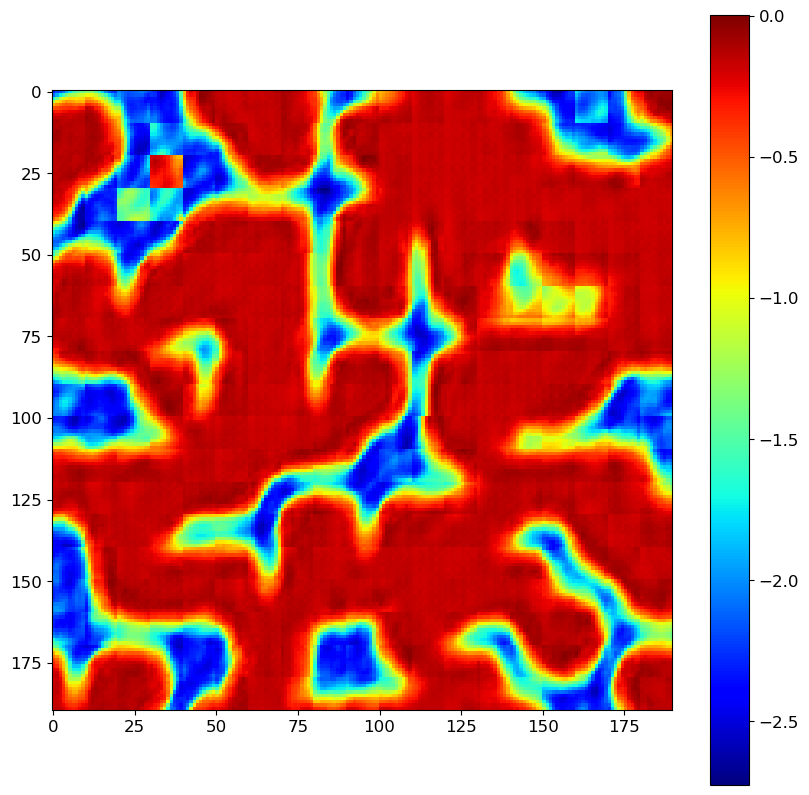

In [231]:
plt.imshow(arrdict['PINN,NLL,overlaps']['stitched_obj_phase'], cmap = 'jet')
plt.colorbar()

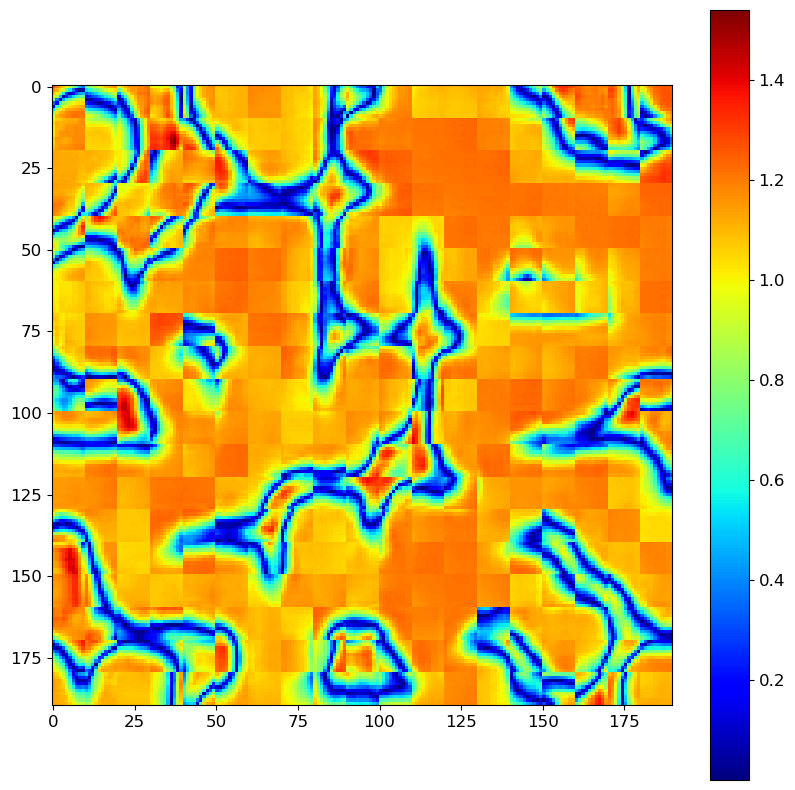

In [232]:
plt.imshow(arrdict['none']['stitched_obj_phase'], cmap = 'jet')
plt.colorbar()

In [235]:
gt = (arrdict['PINN,NLL,overlaps']['YY_ground_truth_amp'], arrdict['PINN,NLL,overlaps']['YY_ground_truth_phi'])

# assert list(recons.keys()) == ['PINN', 'PINN,NLL,overlaps', 'none', 'PINN,NLL', 'overlaps', 'PINN,overlaps']


img_path_map = {'none': (f'images/ptychoNN_{prefix}.png', f'images/PtychoNN_phi_{prefix}.png'),
               'PINN,NLL,overlaps': (f'images/PINN_{prefix}.png', f'images/PtychoPINN_phi_{prefix}.png')}

gt_paths = (f'images/ground_truth_{prefix}.png', f'images/gt_phi_{prefix}.png')

print(img_path_map)
print(gt_paths)

phi_colorbar = False
# Save ground truth amplitude and phase
save_image(gt[0], gt_paths[0])
save_image(gt[1], gt_paths[1], add_colorbar=phi_colorbar)

import zipfile
import os

def save_image(data, path, cmap='jet', add_colorbar=False, colorbar_fontsize=24):
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cmap)
    # Hide tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    if add_colorbar:
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=colorbar_fontsize)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Function to add files to a zip archive
def add_to_zip(zipf, path):
    zipf.write(path)

# Creating the zip archive
zipf = zipfile.ZipFile('Images.zip', 'w', zipfile.ZIP_DEFLATED)

# Save ground truth amplitude and phase
save_image(gt[0], gt_paths[0])
add_to_zip(zipf, gt_paths[0])
save_image(gt[1], gt_paths[1], add_colorbar=phi_colorbar)
add_to_zip(zipf, gt_paths[1])

# Save reconstructions
for key in img_path_map:
    amp_path, phase_path = img_path_map[key]
    save_image(recons[key]['stitched_obj_amp'], amp_path)
    add_to_zip(zipf, amp_path)
    save_image(recons[key]['stitched_obj_phase'], phase_path, add_colorbar=phi_colorbar)
    add_to_zip(zipf, phase_path)

# Closing the zip archive
zipf.close()

{'none': ('images/ptychoNN_experimental.png', 'images/PtychoNN_phi_experimental.png'), 'PINN,NLL,overlaps': ('images/PINN_experimental.png', 'images/PtychoPINN_phi_experimental.png')}
('images/ground_truth_experimental.png', 'images/gt_phi_experimental.png')


In [ ]:
# Function to filter out outliers
def filter_outliers(group, threshold=0.5):
    numeric_cols = group.select_dtypes(include='number')
    return group[(numeric_cols < (1 + threshold) * numeric_cols.mean()).all(axis=1)]

# Apply the function to each group and aggregate by averaging
# result = grouped.apply(filter_outliers).groupby(level=[0, 1]).mean()


result = pd.DataFrame(result.stack())

result = result.unstack(1)


#df = df.groupby(level = [0, 1]).agg('mean')